<a href="https://colab.research.google.com/github/cagBRT/Data/blob/main/5b_Outliers_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://towardsdatascience.com/are-outliers-harder-to-predict-ae84dd4be465

In this notebook we work with outliers.  <br>
We try to answer the question, what should we do with outliers?.

Outliers are individuals that are very different from the majority of the population. Traditionally, among practitioners there is a certain mistrust in outliers, this is why ad-hoc measures such as removing them from the dataset are often adopted.

Sometimes, they are even more important than other observations! <br>

Take for instance the case of individuals that are outliers because they are very high-paying customers: you don’t want to discard them, actually, you probably want to treat them with extra care.

Is an ML model more likely to make mistakes when making predictions on outliers?



To sum up, we may imagine three possibilities:

outliers are harder to predict<br>
outliers are easier to predict<br>
outliers are neither harder nor easier to predict<br>


In [ ]:
!pip install pycaret --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.9/485.9 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 15.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 37.6 MB/s 

In [ ]:
import numpy as np
import pandas as pd
from pycaret.datasets import get_data
from scipy.stats import percentileofscore
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.ensemble import IsolationForest
from category_encoders import CatBoostEncoder
from lightgbm import LGBMClassifier
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
DATASET_NAMES = [ "bank", "blood", "cancer", "credit", "diabetes", "electrical_grid",
                 "employee", "heart", "heart_disease", "hepatitis", "income", "juice",
                 "nba", "wine", "telescope", "titanic", "us_presidential_election_results"]

**Define functions for use in this notebook**

In [ ]:
def get_dataset(dataset_name):
  """Get dataset."""
  target_name = datasets.loc[datasets["Dataset"]==dataset_name, "Target Variable 1"]
  df = get_data(dataset_name, verbose=False)
  X, y = df.drop(target_name, axis=1), df[target_name]
  y = y.replace({yval: binval for yval, binval in zip(y.value_counts().index, [0,1])}).iloc[:,0]
  num_features = X.columns[X.apply(is_numeric)].tolist()
  cat_features = [c for c in X.columns if c not in num_features]
  return X, y, num_features, cat_features

def is_numeric(x):
  """Check whether an object is numeric."""
  try:
    x+0
    return True
  except:
    return False

def individual_log_loss(y_true, y_pred, eps=1e-15):
  """Compute log-loss for each individual of the sample."""
  y_pred = np.clip(y_pred, eps, 1 - eps)
  return - y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred)

**Plot the data**

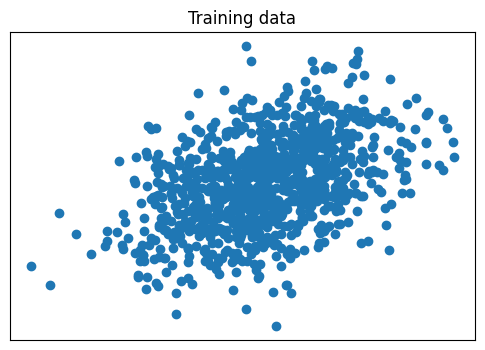

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
x = np.random.multivariate_normal([0,0], [[1,.6],[.6,2]], size=1000)
ax.scatter(x[:,0], x[:,1])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Training data")
fig.savefig(f"example_training.png", dpi=200, bbox_inches="tight")

We will add two data points.<br>

- An outlier datapoint<br>
- A standard datapoint (data in a dense area of training points)

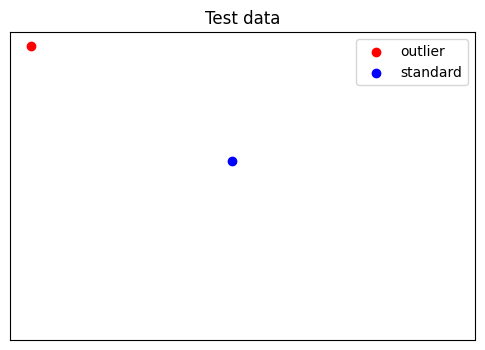

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x[:,0], x[:,1], color="white")
ax.scatter(np.min(x, axis=0)[0], np.max(x, axis=0)[1], color="red", label="outlier")
ax.scatter(np.quantile(x, q=.3, axis=0)[0], np.quantile(x, q=.7, axis=0)[1], color="blue", label="standard")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Test data")
ax.legend(loc="upper right")
fig.savefig(f"example_test.png", dpi=200, bbox_inches="tight")

**Get the bank dataset**<br>
The dataset contains: <br>
- Personal information: age, job, education level, and marital status<br>
- account information: balance, credit status,housing loan status, personal loan status<br>
- marketing information: contact method, day of week of last contact, month of last contact, length of last contact, number of contacts, number of contacts, outcome of last campaign<br>
<br>

Label: the label will predict if the customer will purchase a bank term deposit (Yes=1, No=0)

In [ ]:
datasets = get_data(verbose=False)

"bank": https://www.kaggle.com/datasets/rashmiranu/banking-dataset-classification<br>

"telescope": https://archive.ics.uci.edu/dataset/159/magic+gamma+telescope

**Prepare the dataset**

In [ ]:
dataset_name = "bank"
X, y, num_features, cat_features = get_dataset(dataset_name)
X_train, X_test, y_train, y_test = train_test_split(X, y)
print("Training set:",X_train.shape, y_train.shape)
print("Test set:",X_test.shape, y_test.shape)

Training set: (33908, 16) (33908,)
Test set: (11303, 16) (11303,)




---



---



---



## CatBoost Encoding

CatBooset encoding is used for categorical features.<br>
There are various categorical encoding methods available. Catboost is one of them. <br>

Catboost is a target-based categorical encoder. It is a supervised encoder that encodes categorical columns according to the target value. It supports binomial and continuous targets.

**A quick example of CatBootEncoder**

In [ ]:
# Make dataset
train = pd.DataFrame({
    'color': ["red", "blue", "blue", "green", "red",
              "red", "black", "black", "blue", "green"],

    'interests': ["sketching", "painting", "instruments",
                  "sketching", "painting", "video games",
                  "painting", "instruments", "sketching",
                  "sketching"],

    'height': [68, 64, 87, 45, 54, 64, 67, 98, 90, 87],

    'grade': [1, 2, 3, 2, 3, 1, 4, 4, 2, 3], })

# Define train and target
target = train[['grade']]
train = train.drop('grade', axis = 1)

# Define catboost encoder
cbe_encoder = CatBoostEncoder()

# Fit encoder and transform the features
cbe_encoder.fit(train, target)
train_cbe = cbe_encoder.transform(train)

# We can use fit_transform() instead of fit()
# and transform() separately as follows:
# train_cbe = cbe_encoder.fit_transform(train,target)
train_cbe

,color,interests,height
0,1.875,2.100000,68
1,2.375,2.875000,64
2,2.375,3.166667,87
3,2.500,2.100000,45
4,1.875,2.875000,54
5,1.875,2.500000,64
6,3.500,2.875000,67
7,3.500,3.166667,98
8,2.375,2.100000,90
9,2.500,2.100000,87




---

**End of CatBoostEncoder Example**

---



## Use CatBoostEncoder on our dataset

In [ ]:
cat_encoder = CatBoostEncoder().fit(X_train[cat_features].fillna("NULL"), y_train)
cat_encoder

CatBoostEncoder(cols=['job', 'marital', 'education', 'default', 'housing',
                      'loan', 'contact', 'month', 'poutcome'])

In [ ]:
X_train[cat_features] = cat_encoder.transform(X_train[cat_features])
X_test[cat_features] = cat_encoder.transform(X_test[cat_features])
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_train.mean())

In [ ]:
iforest = IsolationForest(n_estimators = 100).fit(X_train)
iforest_scores_test = pd.Series(-iforest.score_samples(X_test), index=X_test.index)

model = LGBMClassifier(verbose=-1).fit(X_train, y_train)
pred_test = pd.Series(model.predict_proba(X_test)[:,1], index=X_test.index)
logloss_test = individual_log_loss(y_test, pred_test)

In [ ]:
X.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown


In [ ]:
id = iforest_scores_test.sort_values().tail(1).index[0]
x = X_train.apply(lambda col: percentileofscore(col, X_test.loc[id, col.name])).sort_values(key=lambda x: np.abs(50-x), ascending=False).rename("quantile") / 100
out = pd.concat([ X.loc[id, x.index].rename("original data"), x ], axis=1).round(2)
out[(out["quantile"] > .95) | (out["quantile"] < .05)]

,original data,quantile
pdays,808,1.00
duration,5,0.00
previous,12,1.00
month,oct,0.96


In [ ]:
pd.concat([iforest_scores_test.rename("outlierness_test"), logloss_test.rename("logloss_test")], axis=1).head()

,outlierness_test,logloss_test
18292,0.525481,0.002073
23704,0.475567,0.000425
42594,0.425688,0.004887
19871,0.378089,0.112318
21185,0.403515,0.070046


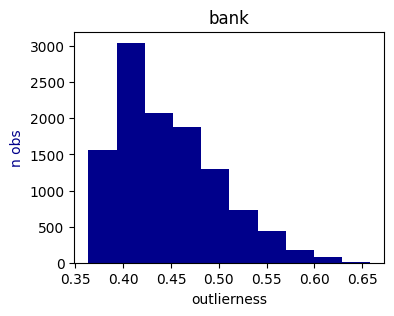

In [ ]:
fig, ax1 = plt.subplots(figsize=(4,3))
ax1.hist(iforest_scores_test, color="darkblue")
ax1.set_title(dataset_name)
ax1.set_xlabel("outlierness")
ax1.set_ylabel("n obs", color="darkblue")
fig.savefig(f"{dataset_name}_hist.png", dpi=200, bbox_inches="tight")

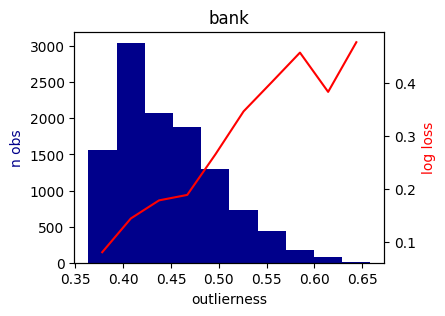

In [ ]:
cut=pd.cut(iforest_scores_test, bins=10)
logloss = logloss_test.groupby(cut).mean()
fig, ax1 = plt.subplots(figsize=(4,3))
ax2 = ax1.twinx()
ax1.hist(iforest_scores_test, color="darkblue")
ax2.plot([i.mid for i in logloss.index], logloss, color="red")
ax1.set_title(dataset_name)
ax1.set_xlabel("outlierness")
ax1.set_ylabel("n obs", color="darkblue")
ax2.set_ylabel("log loss", color="red")
fig.savefig(f"{dataset_name}_hist_logloss.png", dpi=200, bbox_inches="tight")

Repeat for different datasets

In [ ]:
dataset_names = []
for dataset_name in DATASET_NAMES:
  X, y, num_features, cat_features = get_dataset(dataset_name)
  if len(X) > 5000: dataset_names.append(dataset_name)

In [ ]:
results = []
for dataset_name in tqdm(dataset_names):
  X, y, num_features, cat_features = get_dataset(dataset_name)
  for iteration in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    if len(cat_features) > 0:
       cat_encoder = CatBoostEncoder().fit(X_train[cat_features].fillna("NULL"), y_train)
       X_train[cat_features] = cat_encoder.transform(X_train[cat_features])
       X_test[cat_features] = cat_encoder.transform(X_test[cat_features])
       X_train = X_train.fillna(X_train.mean())
       X_test = X_test.fillna(X_train.mean())
       iforest = IsolationForest(n_estimators = 100).fit(X_train)
       iforest_scores_test = pd.Series(-iforest.score_samples(X_test), index=X_test.index)
       model = LGBMClassifier(verbose=-1).fit(X_train, y_train)
       pred_test = pd.Series(model.predict_proba(X_test)[:,1], index=X_test.index)
       logloss_test = individual_log_loss(y_test, pred_test)
       iforest_q95 = iforest_scores_test.quantile(.95)
       outliers_vs_rest = (iforest_scores_test > iforest_q95).replace({True: "outliers", False: "rest"})
       logloss = logloss_test.groupby(outliers_vs_rest).mean()
       results.append({ "dataset name": dataset_name, "iteration": iteration, "n outliers": (iforest_scores_test > iforest_q95).sum(), "log-loss": logloss.mean(), "log-loss (outliers)": logloss["outliers"], "log-loss (rest)": logloss["rest"] })

100%|██████████| 7/7 [00:20<00:00,  2.95s/it]


In [ ]:
results_agg = pd.DataFrame(results).groupby("dataset name").agg({ "dataset name": lambda x: x.values[0], "iteration": lambda x: len(x), "n outliers": np.min, "log-loss": np.mean, "log-loss (outliers)": np.mean, "log-loss (rest)": np.mean, })
results_agg["ratio"] = np.maximum(results_agg["log-loss (outliers)"], results_agg["log-loss (rest)"]) / np.minimum(results_agg["log-loss (outliers)"], results_agg["log-loss (rest)"])
results_agg = results_agg.sort_values("ratio", ascending=False)

In [ ]:
results_agg.loc[:,["log-loss","log-loss (outliers)","log-loss (rest)"]].round(3).style.apply(lambda x: ["background: red" if (v > results_agg["log-loss"].iloc[e] and x.name =="log-loss (outliers)") else ("background: lightgreen"
                                                                                                                                                                                                               if x.name=="log-loss (outliers)" else "") for e, v in enumerate(x)])

,log-loss,log-loss (outliers),log-loss (rest)
dataset name,,,
bank,0.313000,0.443000,0.182000
employee,0.046000,0.039000,0.052000
income,0.259000,0.237000,0.282000
